In [11]:
!git clone https://github.com/Gr1Lo/direct.git

Cloning into 'direct'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 213 (delta 31), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (213/213), 2.37 MiB | 12.30 MiB/s, done.
Resolving deltas: 100% (83/83), done.


#Climate series

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

#noise generators
def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N));
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S;
        return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def white_noise(f):
    return 1;

#1000-years climate series
Fs = 1000
f = 1.5
sample = 1000
t = np.arange(sample)
y = -2 * np.cos(2 * np.pi * f * t / Fs) + brownian_noise(sample) + white_noise(sample)

years = np.arange(1,1001)
ser = pd.Series(data=y, index=years)
#p = plt.plot(y)

#with open('/content/direct/synthetic_dataset/ser.pickle', 'wb') as handle:
#    pickle.dump(ser, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/direct/synthetic_dataset/ser.pickle', 'rb') as handle:
    ser = pickle.load(handle)

# Trees generator

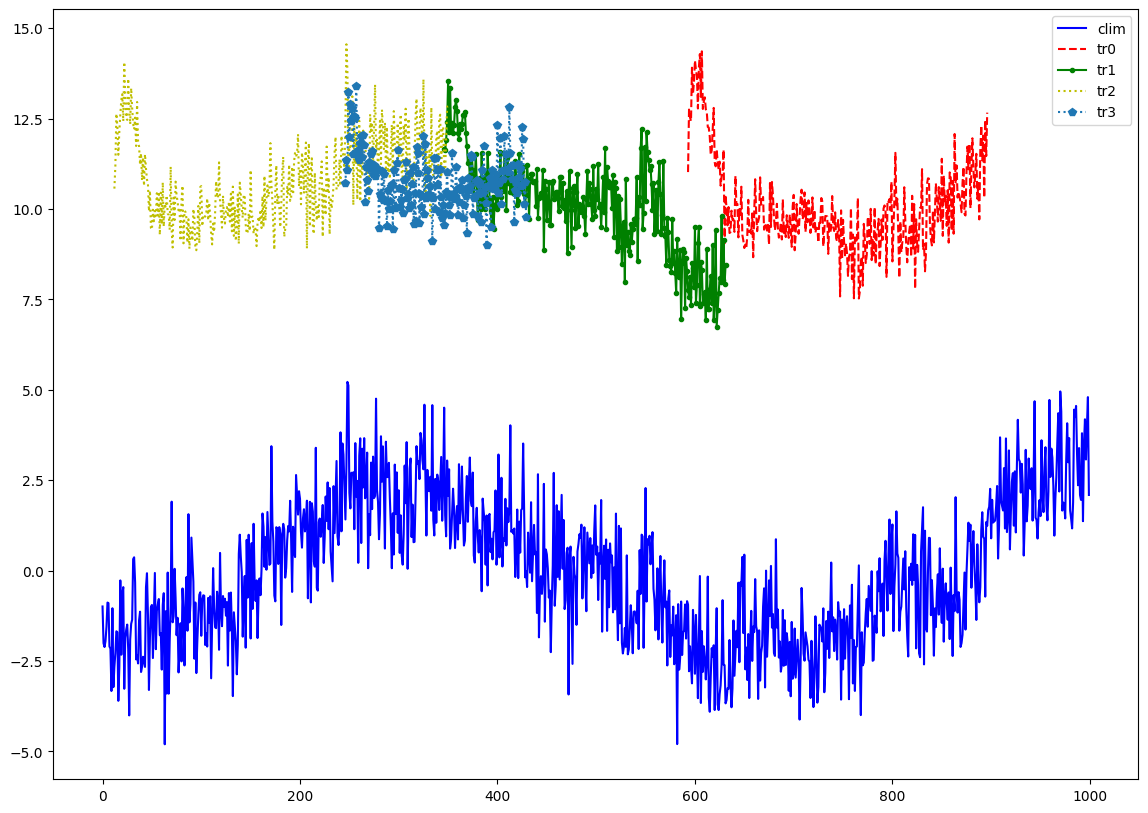

In [14]:
def generate_trees(clim_series, n, mean_age, std_age,
                   hugershoff_a = 0.3, hugershoff_b = 1,
                   hugershoff_c = 0.1, hugershoff_d = 0.1,
                   clim_coef = 0.1, noise_coef=0.1):

    df = clim_series.to_frame()
    df = df.reset_index()
    df = df.rename(columns={"index": "years", 0: "clim"})

    #generating the length of each series
    ages_max = np.int32(np.random.normal(mean_age, std_age, n))
    start_years = np.int32(np.random.uniform(min(clim_series.index),len(clim_series),n))
    for tr in range(len(ages_max)):
          t_ages_max = ages_max[tr]
          if t_ages_max+start_years[tr]>len(clim_series):
              t_ages_max = len(clim_series)-start_years[tr]

          ages = np.arange(1, t_ages_max+1)
          t = np.arange(start_years[tr],start_years[tr]+t_ages_max)

          #hugershoff curve generation
          hugershoff = (hugershoff_a *
                        (ages**hugershoff_b) *
                        np.exp(-hugershoff_c*ages) +
                        hugershoff_d)

          #brownian and white noise addition
          bn = brownian_noise(len(ages)+1) + white_noise(len(ages)+1)
          hugershoff_p_red = hugershoff + noise_coef * bn[:len(hugershoff)]
          exp_var0 = int(mean_age/2)

          exp_var1 = np.random.uniform(0.01, 0.2, 1)[0]

          #sigmoid function for transformation of the climate series
          #with an increase in influence for older individuals
          sigmoid = clim_coef*(0.+(1 / (1 + np.exp(np.float128(-exp_var1*(ages-exp_var0))))))
          if clim_coef==0:
            clim_response = 1*clim_series.values[t]
          else:
            clim_response = np.multiply(clim_series.values[t],sigmoid+0.1)

          hugershoff_p_red_p_clim = hugershoff_p_red + clim_response + 10
          tdf = pd.DataFrame({'years': t,
                              'tr'+str(tr) :hugershoff_p_red_p_clim})

          df = pd.merge(df, tdf, on="years",how='left')

    return df


trdf = generate_trees(ser,
                      n=100,
                      mean_age=300,
                      std_age=50,
                      hugershoff_a = 0.8,
                      hugershoff_b = 1,
                      hugershoff_c = 0.1,
                      hugershoff_d = 0.1,
                      clim_coef = 0.5,
                      noise_coef=0.5)


styles = ['b-','r--','g.-','y:','p:']

trdf.plot(y=['clim']+list(trdf.columns[2:6].values), use_index=True, style=styles,
          figsize=(14,10))


#convert trees to rwl and pth-file
def pandas2rwl(df, rwl_path, pth_path):
    if os.path.exists(pth_path):
        os.remove(pth_path)

    with open(pth_path, 'w',encoding='utf-8') as fpth:
      str_pth = 'series pith.offset\n'
      fpth.write(str_pth)

    if os.path.exists(rwl_path):
        os.remove(rwl_path)
    df = df.sort_values(by=['years'])
    with open(rwl_path, 'w',encoding='utf-8') as f:
      l = list(df.columns.values)
      l.remove('years')
      l.remove('clim')
      for col in l:
          dft = df[["years", col]]
          dft = dft[~dft[col].isnull()]
          str_l = " " * 100
          cou = 0
          val_ind = 18
          for index, row in dft.iterrows():
              val = str((row[col]*100).astype(int))
              year_str = str(int(row['years']))
              if row['years'].astype(int)%10 == 0 or cou==0:
                  if str_l != " " * 100:
                      str_l = str_l.rstrip()+ '\n'
                      f.write(str_l)
                      val_ind = 18
                      str_l = " " * 100

                  str_l = (col + str_l[len(col):])

                  ind0 = 12-len(year_str)
                  str_l = (str_l[:ind0] +
                              year_str +
                              str_l[12:])

                  ind1 = val_ind-len(val)
                  str_l = (str_l[:ind1] +
                              val +
                              str_l[val_ind:])

                  val_ind += 6


              else:
                  ind1 = val_ind-len(val)
                  str_l = (str_l[:ind1] +
                              val +
                              str_l[val_ind:])
                  val_ind += 6

              cou += 1

          val = '-9999'
          year_str = str(int(year_str)+1)
          if int(year_str)%10 == 0 or cou==0:
            str_l = str_l.rstrip()+ '\n'
            f.write(str_l)
            val_ind = 18
            str_l = " " * 100

            str_l = (col + str_l[len(col):])
            ind0 = 12-len(year_str)
            str_l = (str_l[:ind0] + year_str + str_l[12:])
            ind1 = val_ind-len(val)
            str_l = (str_l[:ind1] + val + str_l[val_ind:])
            val_ind += 6
          else:
            ind1 = val_ind-len(val)
            str_l = (str_l[:ind1] + val + str_l[val_ind:])
            val_ind += 6

          str_l = str_l.rstrip()+ '\n'
          f.write(str_l)

          with open(pth_path, 'a',encoding='utf-8') as fpth:
                str_pth = col + ' 1\n'
                fpth.write(str_pth)



#with open('/content/direct/synthetic_dataset/trdf.pickle', 'wb') as handle:
#    pickle.dump(trdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/direct/synthetic_dataset/trdf.pickle', 'rb') as handle:
    trdf = pickle.load(handle)

trdf[['years','clim']].to_csv('/content/direct/synthetic_dataset/clim.csv',
                              index=False,header=False,sep='\t')
pandas2rwl(trdf, '/content/direct/synthetic_dataset/synthetic_ds.rwl',
           '/content/direct/synthetic_dataset/synthetic_ds.pth')